### Analysis software development 

Goal: establish smooth reading of the binary DAQ datafiles

In [1]:
import sys
sys.path.insert(0,'python/')
import struct
import matplotlib.pyplot as plt
import numpy as np

from DT5550 import DT5550

Filename to process

In [2]:
filename = '../daq/ReadoutClient/testdaq/test.data'

Open a datafile and read the data

In [3]:
io = DT5550(file=filename)
while(io.read_event() == 0):
    if io.n_event%1000 == 0:
        print('Processed ',io.n_event,' events')

Processed  1000  events
Processed  2000  events
Processed  3000  events
Processed  4000  events
Processed  5000  events
Processed  6000  events
Processed  7000  events
Processed  8000  events
Processed  9000  events
Processed  10000  events


A few basic plots: integrated charge and time

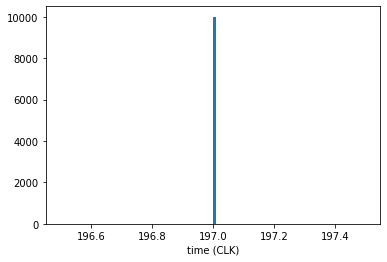

In [8]:
idet = 0
io.plot_time(idet)

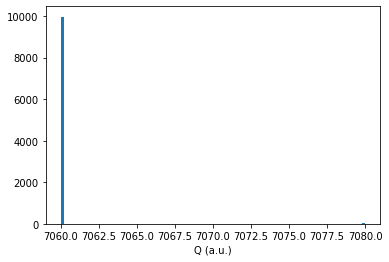

In [11]:
io.plot_charge(0)